## Data == Music
-------------
A predictive model that can predict how highly rated 
music will be based on audio characteristics and 
track information from Spotify!

Let's recall the steps to making a machine learning model:
1. Create a feature matrix and response vector (X and y)
2. Import an estimator class
3. Instantiate that estimator class
4. Fit the model with training data
5. Use the model to predict a new observation
6. Evaluate the model's accuracy
7. ???
8. PROFIT!

We'll be covering steps 1-6.

First we'll import and set up all the packages we'll be using.

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (12.0, 8.0)

import seaborn as sns
sns.color_palette("muted")
sns.set_style("ticks", {'axes.grid': False,
                        'axes.linewidth': 0.5,
                       }
             )

from sklearn import metrics
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from DataEqualsMusic import SpotiAPI

Now let's get our data from a .csv into a DataFrame.
(FYI, you can update the .csv file by running DataEqualsMusic.py.)

In [29]:
file = "data/modified_spotify_top_200.csv"
df = pd.read_csv(file, index_col=0)

# Let's take a look at our data's top 3 entries.
df.head(3)

,Position,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
0,1,0.798,0.156,92.943,0.0432,0.0736,0.00000,4.0,0.608,6.0,185352.0,-5.092,0.488,0.0
1,2,0.524,0.111,95.010,0.0338,0.4140,0.00000,4.0,0.748,8.0,244960.0,-5.599,0.635,1.0
2,3,0.718,0.122,199.864,0.0576,0.0784,0.00001,4.0,0.476,8.0,205947.0,-5.309,0.143,1.0


In [30]:
# Our feature columns are everything after "Position", which is our response variable.
feature_cols = df.columns[1:]

X = df[feature_cols]
y = df.Position

Before we really dig in to the analysis, let's try to visualize any potential relationships in the data.

Are there any overall trends we can see right off the bat?

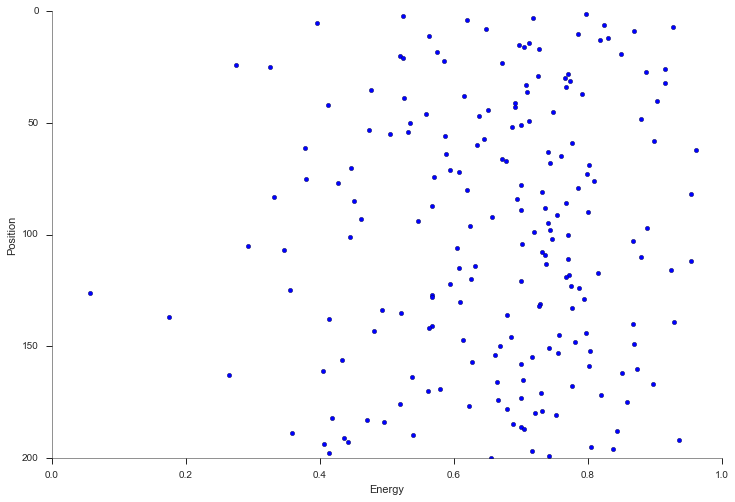

In [48]:
# Let's see if a scatter plot shows us anything.
plt.scatter(df["energy"], y)
plt.xlabel("Energy")
plt.ylabel("Position")

# Set axis limits. The 'energy' feature ranges from 0.0 - 1.0.
# Position ranges from 1 - 200.
plt.axis((0.0,1.0,0,200))

# Invert the y axis (to show rank improving along the y-axis).
plt.gca().invert_yaxis()

# Vanity.
sns.despine()

plt.show()

At least we can see that most of the top 200 tracks tend to be fairly energetic. Let's see where most of them are relative to the others.

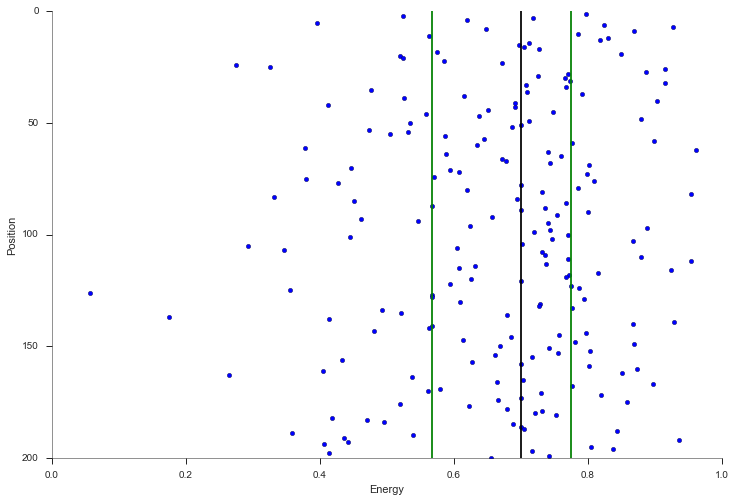

In [47]:
e = df.energy
plt.xlabel("Energy")
plt.ylabel("Position")
p_25 = np.percentile(e, 25) # Returns 25th percentile of the "energy" feature
p_50 = np.percentile(e, 50) 
p_75 = np.percentile(e, 75)

# Same plot as before, plus lines for the percentiles
plt.scatter(df["energy"], y)
plt.axis((0.0,1.0,0,200))
plt.gca().invert_yaxis()
sns.despine()

# Just so we can see them, let's give the lines some colors
plt.axvline(x=p_25, color="Green")
plt.axvline(x=p_50, color="Black")
plt.axvline(x=p_75, color="Green")

plt.show()

In [14]:
print p_25, p_50, p_75

0.567 0.7 0.77425


Well well! From this we can see that most tracks are pretty energetic, like we thought. 

The median energy level is 0.7, which about the norm for artists like Selena Gomez and David Guetta. Before we assume anything though, we should notice that some artists (like Rihanna and Drake) rank highly despite having low-energy songs.

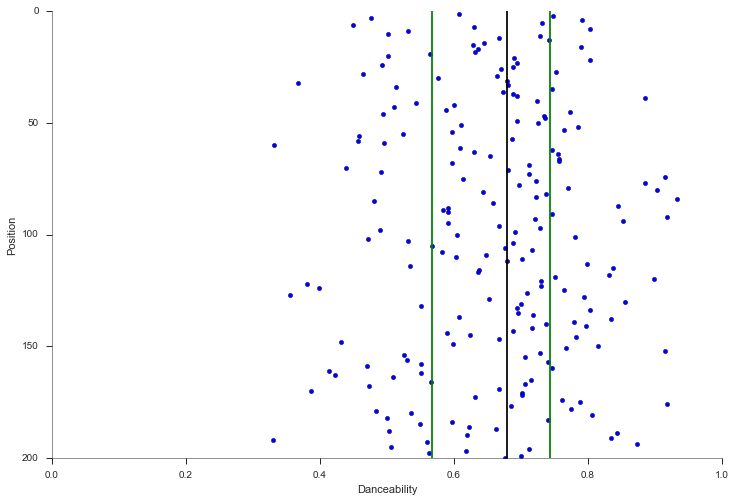

In [46]:
# Let's try the same for danceability
plt.xlabel("Danceability")
plt.ylabel("Position")
d = df.danceability
p_25 = np.percentile(d, 25)
p_50 = np.percentile(d, 50) 
p_75 = np.percentile(d, 75)
plt.scatter(df["danceability"], y)
plt.axis((0.0,1.0,0,200))
plt.gca().invert_yaxis()
sns.despine()
plt.axvline(x=p_25, color="Green")
plt.axvline(x=p_50, color="Black")
plt.axvline(x=p_75, color="Green")

plt.show()

In [16]:
print p_25, p_50, p_75

0.5675 0.68 0.743


To be honest I'm disappointed that most songs have such low danceability, I expected higher.

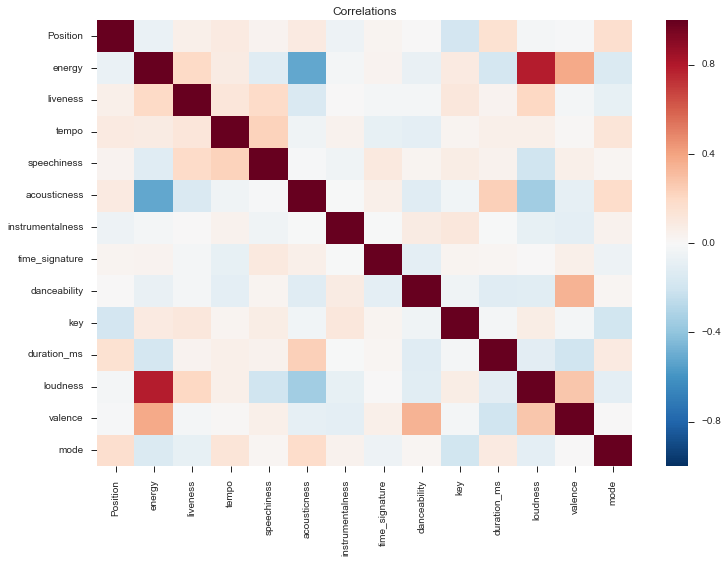

In [44]:
# Find out how predictive features are with a correlation heatmap.
plt.title("Correlations")
sns.heatmap(df.corr())

A track's Position in the global Top 200 charts seems to be:
* Slightly negatively correlated with the track's key
* Slightly positively correlated with the track's mode and duration

## 1. Create a feature matrix and response vector (X and y)

In [34]:
# Our feature columns are everything after "Position", which is our response variable.
feature_cols = df.columns[2:]

X = df[feature_cols]
y = df.Position

In [35]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [36]:
# Let's take a look at the shape of our data.
print X.shape # 200,14. Makes sense; 200 rows and 14 features.
print y.shape # 200,

print X_train.shape # 150, 14
print X_test.shape # 50, 14
print y_train.shape # 150,
print y_test.shape # 50,

(200, 12)
(200,)
(150, 12)
(50, 12)
(150,)
(50,)


At this point, I attempted to make a logistic regression model, fit it to the data, and make predictions with it. 

However, that turned out to be _incredibly_ non-predictive so I scrapped it. 

Unfortunately, I didn't keep a copy for posterity so we're just going to move on to a model that should perform better: RandomForestRegressor!

## 2. Import an estimator class

In [24]:
# Technically, we already did this up top but here it is anyway:
from sklearn.ensemble import RandomForestRegressor

## 3. Instantiate that estimator class

In [37]:
# We'll stick with the default n_estimators=10 for now.
# We'll use the same random state throughout this notebook, 
    # just so that we can be sure no error is due to it.
rf = RandomForestRegressor(random_state=1)

rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

## 4. Fit the model with training data

In [71]:
# Fit our model to our training data.
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

### Feature importance

Another question I had in mind at first was which features would be most important to the outcome.
Let's answer that with an feature importance table, and the resulting graph:

In [27]:
importance = pd.DataFrame({'feature':feature_cols, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
importance.sort_values("importance",ascending=False)

,feature,importance
1,tempo,0.140365
3,acousticness,0.125107
0,liveness,0.115711
2,speechiness,0.104171
8,duration_ms,0.103970
6,danceability,0.093688
9,loudness,0.089968
7,key,0.082803
10,valence,0.072497
4,instrumentalness,0.058212


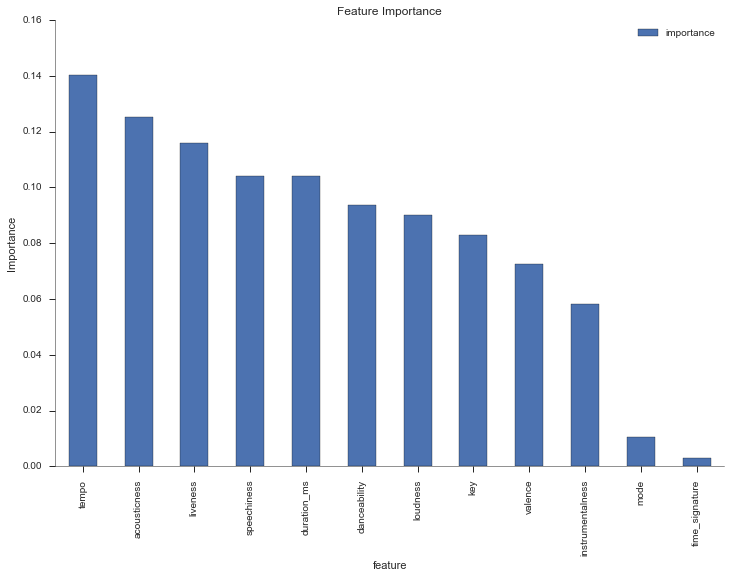

In [70]:
importance.plot(kind="bar", title="Feature Importance", x=importance.feature)
plt.title("Feature Importance")
plt.ylabel("Importance")
sns.despine()

## 5. Use the model to predict a new observation

We previously fit our model to our training data, let's see how our model does!

In [82]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

## 6. Evaluate the model's accuracy

In [83]:
# How good is null accuracy? Shall we guess 50% for now?


In [85]:
# How well did the model do on training data?
rmse(y_train, y_train_pred)

25.335763918487508

In [86]:
# How well did the model do on testing data?
rmse(y_test, y_test_pred)

60.742006881564265

![ouch](http://i381.photobucket.com/albums/oo260/TheDemigodTraveler/GIFs/ouch.gif)

### Tuning n-estimators

That could've gone better. Looks like we have some **HYPERPARAMETER OPTIMIZATION** to do!

In [ ]:
# Let's tune the model a bit and see where that gets us.

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

### Tuning max features

In [ ]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
#create and train the random forest
rf = RandomForestClassifier(n_estimators=100)

X_train, X_test, y_train, y_test
rf.fit(train, target)